#### QUANTUM HARMONIC OSCILLATOR

Let $\Omega = (-1, 1)^2$, $k_1, k_2 \in \mathbb{N}$ and $g \in H^{1/2}(\partial\Omega)$:

$$
    \begin{cases}
            \begin{array}{rl}
                -\frac{1}{2}\Delta u + \frac{1}{2}(x^2 + y^2) \cdot u - (n_x + n_y +1) \cdot u &= \ 0 \text{ in } \Omega, \\
                u &= \ g \text{ on } \partial \Omega.
            \end{array}
        \end{cases}
$$

#### PDE DATA

Let $\lambda = k_1 + k_2 + 1$, $k_1, k_2 \in \mathbb{N}$:

$$
    g(x,y) = \frac{\pi^{-1/4}}{\sqrt{2^{k_1+k_2}k_1!k_2!}}\exp\left(-\frac{x^2+y^2}{2}\right) H_{k_1}(x)H_{k_2}(y).
$$

#### EXPERIMENTS

Experiment 1: $k_1 = k_2 = 15$, $p=\infty$;

Experiment 2: $k_1 = k_2 = 15$, $p=2$;

In [1]:
import numpy as np
import sys
import json
sys.path.insert(1, 'C:/Users/philh/Notebooks/thesis_framework/')
from differentiation import Differentiation
from cubature import Cubature
from benchmark import Benchmark
from utilities import matmul, data_axes, leg_bary, laplacian, inverse_lu, mui_lp_ext, cart
import sympy as sp
import scipy as scipy
prefix = None #"qho"

#### CUBATURE AND DIFFERENTIATION

In [2]:
# DOMAIN #
deg_d = [20]*2
cuba_d = Cubature(deg_d, points="Legendre") # for Lobatto points choose points="Lobatto"
w_d = cuba_d.leja_weights
xs_d = cuba_d.leja_axes
xs_plt_d = cuba_d.axes
bary = cuba_d.leja_axes_bary
diff = Differentiation(xs_d, bary)
nabla = diff.nabla
dx2, dy2 = diff.diffs(np.array([[2,0],[0,2]]))

# BOUNDARY #
deg_b = [100]
cuba_b = Cubature(deg_b)
w_b = cuba_b.leja_weights
xs_b = cuba_b.leja_axes
xs_plt_b = cuba_b.axes

#### LAPLACIAN OPERATORS

In [3]:
I = np.eye(len(w_d))
n_d = np.max(deg_d)

W_d = np.diag(w_d)
W_d_inv = np.linalg.inv(W_d)

M_1, M_1_inv = laplacian(nabla, [W_d_inv]*2 , [W_d]*2)
M_1_s, _ = laplacian(nabla, [W_d_inv]*2, [W_d]*2, weak=True)

M_1_mod = (M_1 + I/n_d**2)
M_1_s_mod = n_d*M_1_s

W_b = np.diag(w_b)

In [4]:
# ABSOLUTE ERROR OF OPERATOR NORM #
print(abs(np.linalg.norm(M_1)-1.0))
print(abs(np.linalg.norm(M_1_s)-1.0))

0.31452544140417626
0.19633107365461933


#### PDE DATA

In [5]:
k_1 = 15
k_2 = 15

def Herm_pol(n):
    p =  sp.Symbol('p')
    Hn = sp.lambdify(p,sp.hermite(n, p))
    return Hn

def Psi (x,y,n_x,n_y):
    Hnx= Herm_pol(k_1)
    Hny= Herm_pol(k_2)
    return 1/((2**(k_1+k_2)*scipy.math.factorial(k_2)*scipy.math.factorial(k_1))**(1/2))*(np.pi**(-1/4))*np.exp(-(x**2+y**2)/2)*Hnx(x)*Hny(y)

def gt(x, y):
    return Psi(x, y, k_1, k_2)

#### $l^p$ DEGREE AND BENCHMARK INITIALIZATION

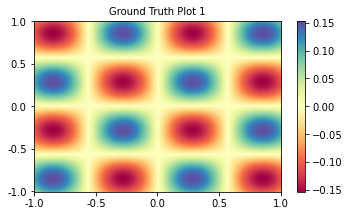

L^2 norm: 0.08347844352796732
L^inf norm: 0.15393917463090112


In [6]:
# l^p #
p = 2
mui = mui_lp_ext(deg_d, p)

# BENCHMARK #
test_xs = [np.linspace(-1.0, 1.0, 249)]*2
data = data_axes(test_xs, mui).T
bm = Benchmark(gt, test_xs, data)
eval_gt = bm.eval_gt()
bm.plot_gt(prefix=prefix)
print(f'L^2 norm: {np.mean(np.array(eval_gt)**2)**0.5}')
print(f'L^inf norm: {np.max(abs(np.array(eval_gt)))}')

#### PDE DATA RESOLUTION

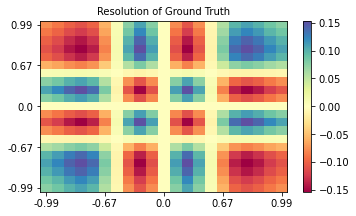

In [7]:
x_plt = cuba_d.grid[:,0]
y_plt = cuba_d.grid[:,1]
shape_plt = [len(xs_plt_d[1]), len(xs_plt_d[0])]

gt_plt = gt(x_plt, y_plt).reshape(*shape_plt)
gt_fn = None#f'{prefix}_pde_data_res_gt'

bm.plot2d(gt_plt, xs_plt_d[0], xs_plt_d[1], title="Resolution of Ground Truth", file_name=gt_fn)

#### REGRESSION UTILITIES

In [8]:
grid_d = cuba_d.leja_grid
crnrs = np.array([-1.0, 1.0])

C_d = data_axes(xs_d, mui).T
C_b = np.concatenate((
    data_axes([xs_b[0], crnrs], mui).T,
    data_axes([crnrs, xs_b[0]], mui).T
))

grid_b0 = cart([xs_b[0], crnrs])
grid_b1 = cart([crnrs, xs_b[0]])

gt_b = np.concatenate((
    gt(grid_b0[:,0], grid_b0[:,1]),
    gt(grid_b1[:,0], grid_b1[:,1])
))

#### DUAL LSQ FORMULATION

In [9]:
def metric(m): return lambda x: matmul(m,x)*x
x = grid_d[:,0]
y = grid_d[:,1]
c = np.diag((x**2+y**2))-2*(k_1+k_2+1)*I
T = -(dx2+dy2)+c
L = lambda u_d, u_b, metric, lam=1.0:\
    sum(w_d*metric(matmul(T, u_d)))+lam*sum(matmul(W_b,(u_b-gt_b)**2))

#### TRUNCATION ERROR

In [10]:
args = [gt(grid_d[:,0], grid_d[:,1]), gt_b]
trunc_err = {
    "L_l2"   : L(*args, metric(I)),
    "L_"     : L(*args, metric(M_1), 1),
    "L_s"    : L(*args, metric(M_1_s), 1),
    "L_mod"  : L(*args, metric(M_1_mod), n_d),
    "L_s_mod": L(*args, metric(M_1_s_mod), n_d)}
print(f'Truncation Errors:\n{json.dumps(trunc_err, indent=5)}')

Truncation Errors:
{
     "L_l2": 1.4288923649243565e-13,
     "L_": 5.617341702293316e-16,
     "L_s": 7.778685940298155e-18,
     "L_mod": 9.189572614604205e-16,
     "L_s_mod": 1.5557371880596315e-16
}


#### SOLUTION

In [11]:
def solution(m1, m2, lam=1.0):
    E = matmul(C_d.T, W_d, m2, C_d)
    TC_d = matmul(T, C_d)
    TC_d_s = matmul(E, TC_d.T, W_d, m1)
    C_b_s = matmul(E, matmul(lam*W_b, C_b).T)
    T_sT_inv = inverse_lu(matmul(TC_d_s, TC_d)+matmul(C_b_s, C_b))
    T_sf = matmul(C_b_s, gt_b)
    theta = matmul(T_sT_inv, T_sf)
    theta = theta.reshape(len(theta),-1)
    return lambda X: np.matmul(np.array(X), theta)

In [12]:
cheb_l2 = solution(I, I)

cheb_ = solution(M_1, M_1_inv, lam=1)
cheb_s = solution(M_1_s, M_1_inv, lam=1)

cheb_mod = solution(M_1_mod, M_1_inv, lam=n_d)
cheb_s_mod = solution(M_1_s_mod, M_1_inv, lam=n_d)

# SET MODELS #
bm.set_model([cheb_l2, cheb_, cheb_s, cheb_mod, cheb_s_mod])

#### MODEL EVALUATION AND PLOT

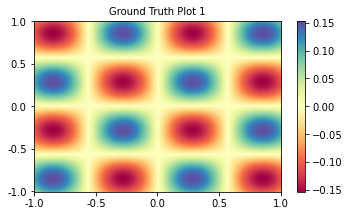

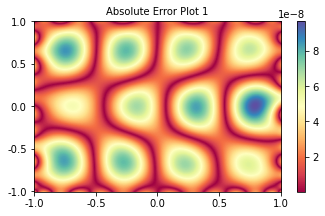

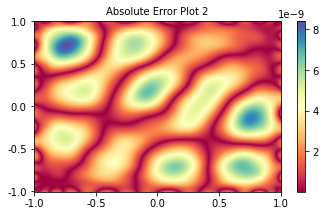

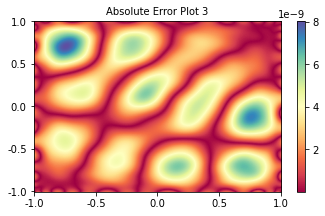

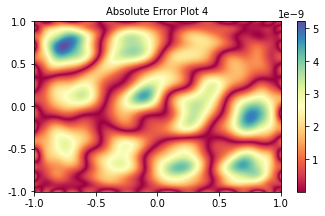

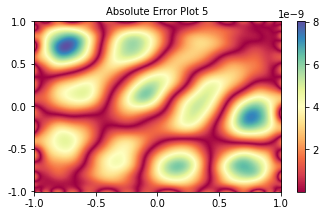

In [13]:
_ = bm.eval_model()
bm.plot_gt(prefix=prefix)
bm.plot_abs_err(prefix=prefix)

#### ERRORS

In [14]:
print(f'L1  Error: \n {bm.lp_err(1, precision=3)}')
print(f'L2  Error: \n {bm.lp_err(2, precision=3)}')
print(f'Max Error: \n {bm.lp_err(np.inf, precision=3)}')

L1  Error: 
 ['3.196e-08', '2.415e-09', '2.301e-09', '1.501e-09', '2.305e-09']
L2  Error: 
 ['3.861e-08', '3.014e-09', '2.872e-09', '1.875e-09', '2.877e-09']
Max Error: 
 ['9.703e-08', '8.429e-09', '8.046e-09', '5.238e-09', '8.059e-09']


#### TABLE FORMAT ERROR

In [15]:
err=np.array(
    [bm.lp_err(2, precision=2),
     bm.lp_err(np.inf, precision=2)])

row = f'{deg_d[0]} '
for _ in err.T:
    row = row + f'& {_[0]} & {_[1]} '
row = row + f'\\\\'

print(row)

20 & 3.86e-08 & 9.70e-08 & 3.01e-09 & 8.43e-09 & 2.87e-09 & 8.05e-09 & 1.87e-09 & 5.24e-09 & 2.88e-09 & 8.06e-09 \\
